# MNIST digit classification

For detailed explanations, refer to:
* this [link](https://victorzhou.com/blog/keras-neural-network-tutorial/) for the MLP
* [here](https://victorzhou.com/blog/keras-cnn-tutorial/) for the simple CNN, and to this Kaggle [kernel](https://www.kaggle.com/anebzt/mnist-with-cnn-in-keras-detailed-explanation) for additional information on implementing CNN

On optimizing the CNN: 
this awesome Kaggle [kernel](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist) and  
[Keras documentation](https://keras.io/examples/mnist_cnn/)

In [1]:
# import
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# keras import
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical

# visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#set figure size
plt.rcParams['figure.figsize'] = 9, 6
import seaborn as sns
sns.set_style('white')

from random import randrange

Using TensorFlow backend.


In [2]:
# load data
data_set = pd.read_csv('./input/train.csv')
print(data_set.shape)

(42000, 785)


In [3]:
data_set.sample(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
18971,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12674,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


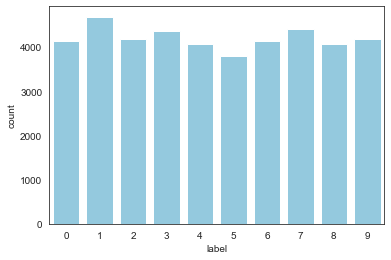

In [4]:
# segregate training data set in pixel features and label
y = data_set['label']
X = data_set.drop(labels = ['label'], axis=1) 
# free memory
del data_set

# check distribution of the handwritten digits
sns.countplot(y, color='skyblue');

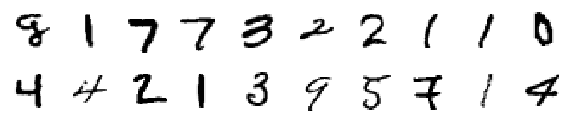

In [5]:
# show multiple images chosen randomly 
fig, axs = plt.subplots(2, 10, figsize=(10, 2)) # 2 rows of 10 images

for ax in axs.flat:
    i = randrange(X.shape[0])
    ax.imshow(X.loc[i].values.reshape(28, 28), cmap='gray_r')
    ax.set_axis_off()

In [6]:
# Normalize pixel value to range 0 to 1
X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## MLP

In [7]:
# define model
model = Sequential([
  Dense(128, activation='relu', input_shape=(784,)),  # change layer size from 64 to 128
  Dropout(0.25),
  Dense(64, activation='sigmoid'), # change activation function from relu to sigmoid
  Dropout(0.25),    
  Dense(10, activation='softmax'),
])

model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [8]:
# Train the model
n_epochs = 10 # increase nbr of epochs from 5 to 10

history = model.fit(
    X_train,
    to_categorical(y_train),
    epochs=n_epochs,  
    validation_data=(X_test, to_categorical(y_test)), 
    batch_size=32,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37800/37800 [==============================] - 37s 973us/step - loss: 0.5236 - acc: 0.8526 - val_loss: 0.2013 - val_acc: 0.9414
Epoch 2/10
37800/37800 [==============================] - 20s 523us/step - loss: 0.2250 - acc: 0.9345 - val_loss: 0.1470 - val_acc: 0.9560
Epoch 3/10
37800/37800 [==============================] - 20s 536us/step - loss: 0.1708 - acc: 0.9506 - val_loss: 0.1186 - val_acc: 0.9633
Epoch 4/10
37800/37800 [==============================] - 22s 590us/step - loss: 0.1404 - acc: 0.9585 - val_loss: 0.1156 - val_acc: 0.9650
Epoch 5/10
37800/37800 [==============================] - 19s 509us/step - loss: 0.1238 - acc: 0.9631 - val_loss: 0.1075 - val_acc: 0.9674
Epoch 6/10
37800/37800 [==============================] - 19s 512us/step - loss: 0.1054 - acc: 0.9685 - val_loss: 0.0999 - val_acc: 0.9705
Epoch 7/10
37800/37800 

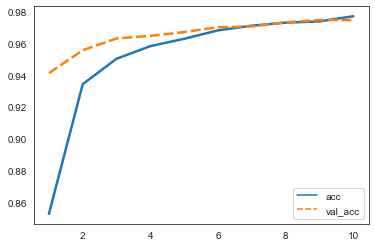

In [9]:
# load history in dataframe and plot accuracy for training and test data
df_history = pd.DataFrame(history.history, index=[i+1 for i in range(n_epochs)])  
sns.lineplot(data=df_history[['acc','val_acc']], palette="tab10", linewidth=2.5);

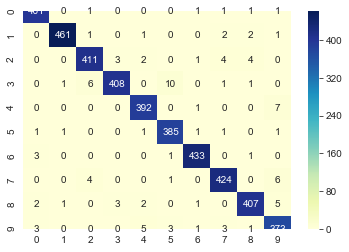

In [10]:
# get prediction for validation set 
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

confusion_mtx = confusion_matrix(y_test, y_pred)
sns.heatmap(data=confusion_mtx, annot=True, fmt='d', cmap='YlGnBu');

In [11]:
# save weights
model.save_weights('./output/mnist_mlp_dropout.h5')

# load test data
test = pd.read_csv('./input/test.csv')

# prediction
y_test = model.predict(test)

In [12]:
# convert to df
submission = pd.DataFrame(data=y_test)

# set label as the 0-9 class with highest value 
submission['Label'] = submission.idxmax(axis=1)
submission['ImageId'] = np.asarray([i+1 for i in range(submission.shape[0])])

submission.to_csv('./output/submission-mlp_dropout.csv', 
                  columns=['ImageId','Label'],
                  header=True,
                  index=False)

## Simple CNN

In [13]:
# Reshape the images
img_size = 28
X_cnn = X.values.reshape(-1, img_size, img_size, 1)
# check 
print(X_cnn.shape)

X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.1)

(42000, 28, 28, 1)


In [14]:
# define model
num_filters = 8
filter_size = 3
pool_size = 2

model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),  
#  Dense(10, activation='sigmoid'),   
#  Dropout(0.25),     
  Dense(10, activation='softmax'),
])

model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [15]:
# Train the model
n_epochs = 10 # increase nbr of epochs from 5 to 10

history = model.fit(
    X_train,
    to_categorical(y_train),
    epochs=n_epochs,  
    validation_data=(X_test, to_categorical(y_test)), 
    batch_size=64,
)

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37800/37800 [==============================] - 44s 1ms/step - loss: 0.4824 - acc: 0.8703 - val_loss: 0.2948 - val_acc: 0.9174
Epoch 2/10
37800/37800 [==============================] - 37s 991us/step - loss: 0.2403 - acc: 0.9319 - val_loss: 0.2342 - val_acc: 0.9319
Epoch 3/10
37800/37800 [==============================] - 38s 1ms/step - loss: 0.1865 - acc: 0.9484 - val_loss: 0.1901 - val_acc: 0.9455
Epoch 4/10
37800/37800 [==============================] - 38s 1ms/step - loss: 0.1519 - acc: 0.9574 - val_loss: 0.1715 - val_acc: 0.9531
Epoch 5/10
37800/37800 [==============================] - 40s 1ms/step - loss: 0.1276 - acc: 0.9641 - val_loss: 0.1483 - val_acc: 0.9571
Epoch 6/10
37800/37800 [==============================] - 39s 1ms/step - loss: 0.1105 - acc: 0.9693 - val_loss: 0.1391 - val_acc: 0.9586
Epoch 7/10
37800/37800 [==============================] - 38s 1ms/step - loss: 0.0982 - acc: 0.9731 - val_loss: 0.1273 - val_ac

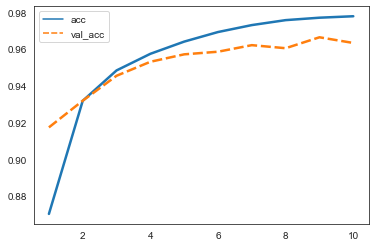

In [16]:
# load history in dataframe and plot accuracy for training and test data
df_history = pd.DataFrame(history.history, index=[i+1 for i in range(n_epochs)])  
sns.lineplot(data=df_history[['acc','val_acc']], palette="tab10", linewidth=2.5);